In [1]:
import pandas as pd
from gensim.models import FastText
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns

### 임베딩

In [2]:
df = pd.read_csv('data/전국_시군구_키워드.csv')

In [3]:
df.head()

,시도,시군구,code,keyword
0,강원특별자치도,강릉시,42150,면사무소 로컬 미니 소장 희망이 런치 랜드마크 허브 지평선 연결하다 유형문화재 경쟁...
1,강원특별자치도,고성군,42820,대표 벚꽃 조명 마당 공연장 항상 모형 검색 특징 생태 촉촉하다 가성 사진촬영 힐링...
2,강원특별자치도,동해시,42170,당연하다 주소 전혀 전국 조선시대 건물 주변 운치 대표 벚꽃 자연환경 자리 생명 연...
3,강원특별자치도,삼척시,42230,여전하다 오늘 가을 성하다 역사 정갈하다 일상 대충 차다 검색 새롭다 내용 갈다 익...
4,강원특별자치도,속초시,42210,이루다 번의 몽환 화려하다 길어지다 용하다 싱겁다 커피한잔 평일 어린이집 전의 돈까...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   시도       250 non-null    object
 1   시군구      250 non-null    object
 2   code     250 non-null    int64 
 3   keyword  250 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.9+ KB


In [5]:
# 사전 학습된 한국어 FastText 모델 로드
model_path = 'model/cc.ko.300.bin'  # 300차원의 임베딩 벡터 제공
model = FastText.load_fasttext_format(model_path)

C:\Users\82109\AppData\Local\Temp\ipykernel_18012\2426146720.py:3: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  model = FastText.load_fasttext_format(model_path)


In [6]:
# 단어 벡터의 평균을 계산하는 함수
def average_word_vectors(words, model, num_features):
    # 모든 성분이 0인 num_features 차원의 초기 벡터 생성
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        nwords = nwords + 1.
        # 모든 단어 벡터의 합 계산
        feature_vector = np.add(feature_vector, model.wv[word])
    # nwords가 0이 아닌 경우 평균 벡터 계산
    if nwords:
        average_vector = np.divide(feature_vector, nwords)
    return average_vector

In [7]:
# FastText 모델을 사용해 키워드를 평균 벡터로 변환
df['average_vector'] = df['keyword'].apply(lambda x : average_word_vectors(x, model, model.vector_size))

### 군집화

In [8]:
# 엘보우 메서드를 사용해 군집화 왜곡 평가
max_k = 15  
inertias = []
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df['average_vector'].tolist())
    inertias.append(kmeans.inertia_)

C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

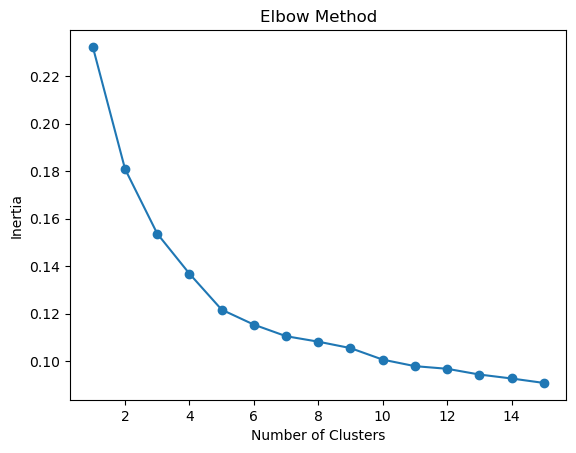

In [9]:
# 엘보우 메서드 그래프 시각화
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [10]:
# KMeans 군집화 수행
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df['average_vector'].tolist())

C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [11]:
# 실루엣 스코어 계산
range_n_clusters = list(range(5, 11))  
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df['average_vector'].tolist())
    silhouette_avg = silhouette_score(df['average_vector'].tolist(), cluster_labels)
    print(f"클러스터 개수: {n_clusters}, 평균 실루엣 스코어: {silhouette_avg}")

C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


클러스터 개수: 5, 평균 실루엣 스코어: 0.17834335931635922


C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


클러스터 개수: 6, 평균 실루엣 스코어: 0.13877971246248835


C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


클러스터 개수: 7, 평균 실루엣 스코어: 0.14226418205402144


C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


클러스터 개수: 8, 평균 실루엣 스코어: 0.10920267061930777


C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


클러스터 개수: 9, 평균 실루엣 스코어: 0.10489667601879935


C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\82109\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


클러스터 개수: 10, 평균 실루엣 스코어: 0.11286716366836615


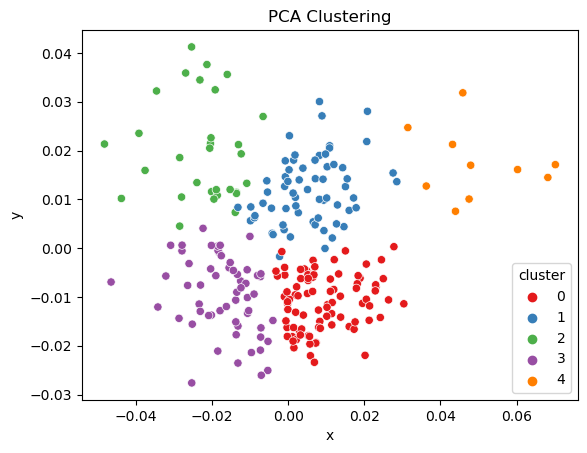

In [12]:
# PCA를 사용해 데이터를 2차원으로 축소 및 시각화
pca = PCA(n_components=2)
df['x'] = pca.fit_transform(df['average_vector'].tolist())[:, 0]
df['y'] = pca.fit_transform(df['average_vector'].tolist())[:, 1]
sns.scatterplot(x="x", y="y", hue="cluster", palette=sns.color_palette("Set1", 5), data=df)
plt.title('PCA Clustering')
plt.show()

In [13]:
df = df[['시도', '시군구', 'code', 'average_vector', 'cluster']]

In [14]:
df.head()

,시도,시군구,code,average_vector,cluster
0,강원특별자치도,강릉시,42150,"[-0.011819980646558582, -0.03340657105738541, ...",2
1,강원특별자치도,고성군,42820,"[-0.012841725631746967, -0.03517293079568503, ...",1
2,강원특별자치도,동해시,42170,"[-0.01224813041892335, -0.03311602418559692, -...",0
3,강원특별자치도,삼척시,42230,"[-0.011352222225247302, -0.033782733047451316,...",0
4,강원특별자치도,속초시,42210,"[-0.013214555778519802, -0.03378213531928128, ...",3


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   시도              250 non-null    object
 1   시군구             250 non-null    object
 2   code            250 non-null    int64 
 3   average_vector  250 non-null    object
 4   cluster         250 non-null    int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 8.9+ KB


In [16]:
df.to_csv('data/전국_시군구_군집.csv', encoding='utf-8-sig', index=False)